In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

In [ ]:
def plot_gan_training(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

# Task 1 (4 points): Vanila GAN for 1d task

In this task you will train simple GAN model for 1d distribution.

In [ ]:
def generate_1d_data(count):
    gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(count // 2,))
    gaussian2 = np.random.normal(loc=0.5, scale=0.5, size=(count // 2,))
    data = (np.concatenate([gaussian1, gaussian2]) + 1).reshape([-1, 1])
    return (data - data.min()) / (data.max() - data.min())


def visualize_1d_data(data):
    plt.figure(figsize=(7, 4))
    plt.hist(data, bins=50)
    plt.show()

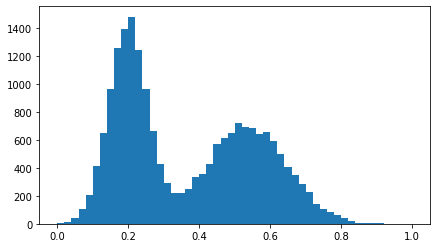

In [ ]:
COUNT = 20000

train_data = generate_1d_data(COUNT)
visualize_1d_data(train_data)

In [ ]:
def make_step(loss_fn, x, generator, discriminator, optimizer):
    loss = loss_fn(generator, discriminator, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


def train_epoch(
    generator, 
    discriminator, 
    gen_loss_fn, 
    discr_loss_fn, 
    train_loader, 
    gen_optimizer, 
    discr_optimizer, 
    discr_steps=1
):
    generator.train()
    discriminator.train()

    gen_losses, discr_losses = [], []
    for idx, x in enumerate(train_loader):
        x = x.cuda().float()
        discr_loss = make_step(discr_loss_fn, x, generator, discriminator, discr_optimizer)
        discr_losses.append(discr_loss.item())

        if idx % discr_steps == 0:
            gen_loss = make_step(gen_loss_fn, x, generator, discriminator, gen_optimizer)
            gen_losses.append(gen_loss.item())
    return {
        'generator_losses': gen_losses,
        'discriminator_losses': discr_losses
    }


def train_model(
    generator, 
    discriminator, 
    gen_loss_fn, 
    discr_loss_fn, 
    train_loader, 
    epochs,
    lr,
    discr_steps=1
):
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    discr_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))

    train_losses = {}
    for epoch in range(epochs):
        train_loss = train_epoch(
            generator, 
            discriminator, 
            gen_loss_fn, 
            discr_loss_fn,
            train_loader, 
            gen_optimizer, 
            discr_optimizer, 
            discr_steps=discr_steps
        )
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    return train_losses

Generator and Discriminator models are simple MLP models.

The objective function is 
$$min_{G} max_{D} \mathbb{E}_{\mathbf{x} \sim \pi(\mathbf{x})} [\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log (1-D(G(\mathbf{z})))]$$

In [ ]:
class FullyConnectedMLP(nn.Module):
    # do not change this class
    def __init__(self, input_dim, hiddens, output_dim):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hiddens = hiddens
        
        
        # ====
        # your code
        model = []
        in_dim = input_dim
        for out_dim in hiddens:
            model.append(nn.Linear(in_dim, out_dim))
            model.append(nn.ReLU())
            in_dim = out_dim
        model.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*model).cuda()
        # ====

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, self.output_dim)


class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, hiddens, data_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = FullyConnectedMLP(latent_dim, hiddens, data_dim)
    
    def forward(self, z):
        # ====
        # your code
        # apply mlp and (!)sigmoid activation
        out = self.mlp(z.cuda())
        return torch.sigmoid(out)
        # ====
        
    def sample(self, n):
        # ====
        # your code
        # sample from uniform and apply the model
        return self.forward(torch.rand((n, self.latent_dim))).cuda()
        # ====

class MLPDiscriminator(nn.Module):
    def __init__(self, latent_dim, hiddens, data_dim):
        super().__init__()
        self.mlp = FullyConnectedMLP(latent_dim, hiddens, data_dim)
    
    def forward(self, z):
        # ====
        # your code
        # apply mlp and sigmoid activation
        out = self.mlp(z.cuda())
        return torch.sigmoid(out)
        # ====

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 64
GEN_HIDDENS = [128, 128, 128]
DISCR_HIDDENS = [128, 128, 128]
EPOCHS = 100
LR = 2e-4
DISCR_STEPS = 5
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# model
generator = MLPGenerator(latent_dim=1, hiddens=GEN_HIDDENS, data_dim=1).cuda()
discriminator = MLPDiscriminator(latent_dim=1, hiddens=DISCR_HIDDENS, data_dim=1).cuda()


def gen_loss(generator, discriminator, x):
    # ====
    # your code
    # sample data from generator (number of samples = x.shape[0])
    fake_data = generator.sample(x.shape[0])
    return torch.log(1 - discriminator(fake_data)).mean()# log(1 - D(x))
    # ====


def discr_loss(generator, discriminator, x):
    # ====
    # your code
    # sample data from generator (number of samples = x.shape[0])
    with torch.no_grad():
        fake_data = generator.sample(x.shape[0])
    return -1 * (torch.log(discriminator(x)) + torch.log(1 - discriminator(fake_data))).mean() # - log(D(x_real)) - log(1 - D(x_fake))
    # ====
    
# train
train_losses = train_model(
    generator, 
    discriminator, 
    gen_loss, 
    discr_loss, 
    train_loader, 
    epochs=EPOCHS,
    lr=LR,
    discr_steps=DISCR_STEPS
)

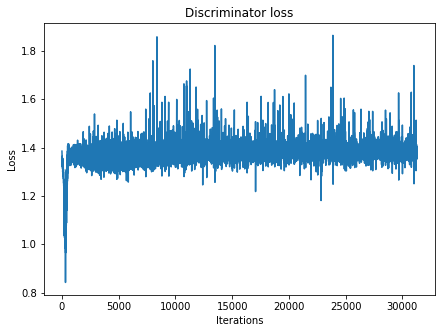

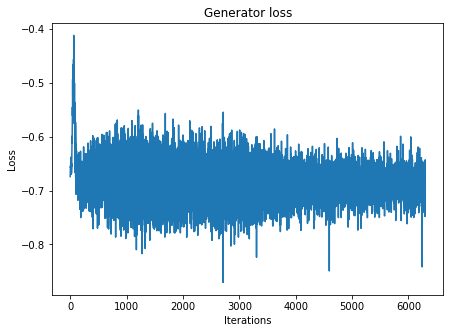

In [ ]:
plot_gan_training(train_losses['discriminator_losses'], 'Discriminator loss')
plot_gan_training(train_losses['generator_losses'], 'Generator loss')

In [ ]:
def make_inference(generator, discriminator, n_samples=5000):
    generator.eval()
    discriminator.eval()
    xs = np.linspace(0, 1, 1000)
    samples = generator.sample(n_samples).cpu().detach().numpy()
    discr_output = discriminator(torch.FloatTensor(xs).cuda().unsqueeze(1)).cpu().detach().numpy()
    return samples, xs, discr_output


def plot_results(data, samples, xs, ys, title):
    plt.figure(figsize=(7, 5))
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='fake')
    plt.hist(data, bins=50, density=True, alpha=0.7, label='real')

    plt.plot(xs, ys, label='discrim')
    plt.legend()
    plt.title(title)

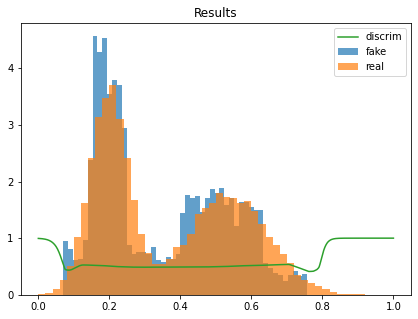

In [ ]:
samples, xs, discr_output = make_inference(generator, discriminator)
plot_results(train_data, samples, xs, discr_output, 'Results')

Now we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{\mathbf{x} \sim \pi(\mathbf{x})} [\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log (1-D(G(\mathbf{z})))]$$
$$L^{(G)} = - \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})} \log(D(G(\mathbf{z}))$$

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 64
GEN_HIDDENS = [128, 128, 128]
DISCR_HIDDENS = [128, 128, 128]
EPOCHS = 100
LR = 2e-4
DISCR_STEPS = 5
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# model
generator = MLPGenerator(latent_dim=1, hiddens=GEN_HIDDENS, data_dim=1).cuda()
discriminator = MLPDiscriminator(latent_dim=1, hiddens=DISCR_HIDDENS, data_dim=1).cuda()


def gen_loss(generator, discriminator, x):
    # ====
    # your code
    # sample data from generator (number of samples = x.shape[0])
    fake_data = generator.sample(x.shape[0])
    return -1 * torch.log(discriminator(fake_data)).mean()# -log(D(x))
    # ====


# train
train_losses = train_model(
    generator, 
    discriminator, 
    gen_loss, 
    discr_loss, 
    train_loader, 
    epochs=EPOCHS,
    lr=LR,
    discr_steps=DISCR_STEPS
)

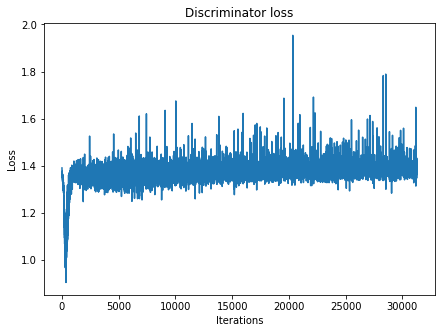

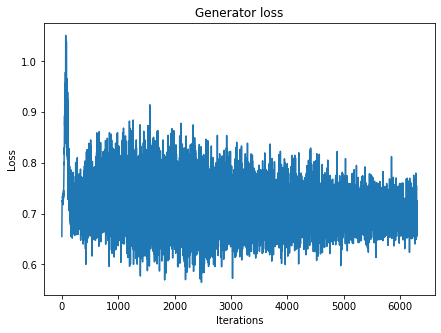

In [ ]:
plot_gan_training(train_losses['discriminator_losses'], 'Discriminator loss')
plot_gan_training(train_losses['generator_losses'], 'Generator loss')

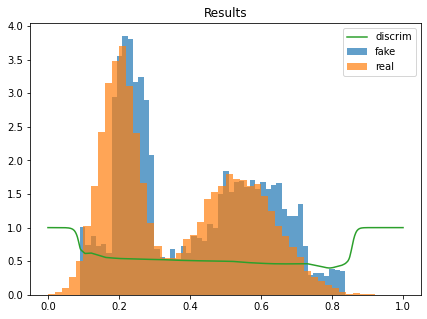

In [ ]:
samples, xs, discr_output = make_inference(generator, discriminator)
plot_results(train_data, samples, xs, discr_output, 'Results')

# Task 2 (4 points): WGAN-GP for CIFAR 10

In this task you will fit Wasserstein GAN with Gradient Penalty model to the CIFAR10 dataset (https://drive.google.com/file/d/16j3nrJV821VOkkuRz7aYam8TyIXLnNme/view?usp=sharing).  

In [ ]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'], data['test']
    return train_data, test_data


def show_samples(samples, title, nrow=10):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title)

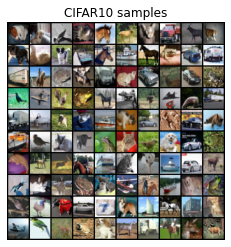

In [ ]:
# train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'DGM2020', 'homework_supplementary', 'cifar10.pkl'))
train_data, test_data = load_pickle(os.path.join('cifar10.pkl'))
visualize_data(train_data, 'CIFAR10 samples')

In [ ]:
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.shape[0]
    # ====
    # your code
    # Calculate interpolation
    # x_t = t * x_real + (1 - t) x_fake
    
    # sample t
    t = torch.rand((batch_size, 1, 1, 1)).cuda()
    
    # create x_t
    # be careful about shapes
    interpolated = t * real_data - (t - 1) * fake_data
    # interpolated.requires_grad = True
    # ====

    # ====
    # your code
    # apply critic to x_t
    d_output = critic(interpolated)
    # ====
    gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                    grad_outputs=torch.ones(d_output.size()).cuda(),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.reshape(batch_size, -1)
    
    # ====
    # your code
    # compute gradient norm
    gradients_norm = torch.norm(gradients, dim=1)
    # ====
    return ((gradients_norm - 1) ** 2).mean()

def train(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs
):
    train_losses = []
    Lambda = 10
    critic.train()
    generator.train()

    curr_iter = 0
    for epoch_i in range(n_epochs):
        batch_loss_history = []

        for batch_i, x in enumerate(tqdm(train_loader, desc=f'epoch {epoch_i}', leave=False)):
            curr_iter += 1
            x = x.clone().detach().cuda().float()
            x = 2 * (x - 0.5)

            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])
            gp = gradient_penalty(critic, x, fake_data)
            # ====
            # your code
            # D(x_fake) - D(x_real) + Lambda (Lambda = 10) * grad_pen
            d_loss = critic(fake_data).mean() - critic(x).mean() + Lambda * gp
            # ====
            d_loss.backward()
            critic_optimizer.step()
            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # ====
                # your code
                # -D(x_fake)
                g_loss = -1 * critic(fake_data).mean()
                # ====
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history.append(g_loss.data.cpu().numpy())

        epoch_loss = np.mean(batch_loss_history)
        train_losses.append(epoch_loss)

    train_losses = np.array(train_losses)
    return train_losses

In [ ]:
class Generator(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        self.dim = dim 
        # ====
        # your code
        # apply linear layer with output units 4 * 4 * 4 * dim, then relu
        self.preprocess = nn.Sequential(
            nn.Linear(128, 4 * 4 * 4 * dim),
            nn.ReLU()
        )
        
        # apply transposed conv with stride 2, kernel size 2
        # then BN, then relu
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * dim, 2 * dim, 2, 2),
            nn.BatchNorm2d(2 * dim),
            nn.ReLU()
        )
        
        # apply transposed conv with stride 2, kernel size 2
        # then BN, then relu
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * dim, dim, 2, 2),
            nn.BatchNorm2d(dim),
            nn.ReLU()
        )
        
        # ====
        self.deconv_out = nn.ConvTranspose2d(dim, 3, 2, stride=2)
        self.tanh = nn.Tanh()
        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4 * self.dim, 4, 4)
        output = self.block1(output)
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.tanh(output)
        return output.view(-1, 3, 32, 32)

    def sample(self, n_samples):
        z = self.noise.sample([n_samples, 128]).cuda()
        return self.forward(z)


class Critic(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        # ====
        # your code
        # sequence of Conv2D with kernel size 3 stride 2 and LeakyRelU
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.LeakyReLU()
        )
        # ====
        self.linear = nn.Linear(4 * 4 * 4 * dim, 1)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1, 4 * 4 * 4 * self.dim)
        output = self.linear(output)
        return output

Total number of epochs: 500


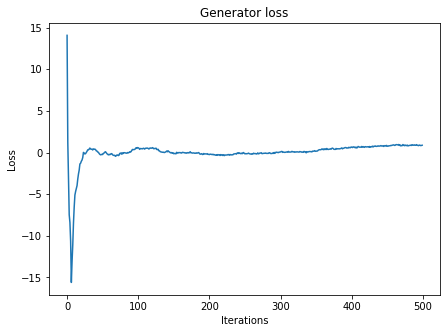

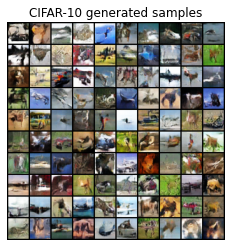

In [ ]:
# train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'DGM2020', 'homework_supplementary', 'cifar10.pkl'))
# train_data, test_data = load_pickle(os.path.join('cifar10.pkl'))
# train_data = np.transpose(train_data, (0, 3, 1, 2)) / 255.0

# ====
# your code
# choose these parameters
BATCH_SIZE = 50 
DIM = 64
N_ITERATIONS = 100000
CRITIC_STEPS = 5
# ====


train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
N_EPOCHS = CRITIC_STEPS * N_ITERATIONS // len(train_loader)
print('Total number of epochs:', N_EPOCHS)

generator = Generator(dim=DIM).cuda()
critic = Critic(dim=DIM).cuda()

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0, 0.9))
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=2e-4, betas=(0, 0.9))

losses = train(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    CRITIC_STEPS, 
    BATCH_SIZE, 
    N_EPOCHS
)

plot_gan_training(losses, 'Generator loss')

generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.permute(0, 2, 3, 1).cpu().detach().numpy() * 0.5 + 0.5
    

show_samples(samples[:100] * 255.0, title='CIFAR-10 generated samples')

# Task 3 (4 points): WGAN vs WGAN-GP

Here your task is reproduce the experiment with a toy dataset from https://arxiv.org/pdf/1704.00028.pdf


NN architectures and hyperparameters should be the same as in the author's implementation (except defined)

In [ ]:
def make_inference(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-3, 3, 1000)
    xg, yg = np.meshgrid(xs, xs)
    grid = np.concatenate((xg.reshape(-1, 1), yg.reshape(-1, 1)), axis=-1)
    samples = generator.sample(n_samples).cpu().detach().numpy()
    critic_output = critic(torch.FloatTensor(grid).cuda()).cpu().detach().numpy()
    critic_output = np.prod(critic_output, axis=-1).reshape((1000, 1000))
    return samples, grid, critic_output


def visualize_2d_data(train_data, train_labels=None):
    plt.figure(figsize=(7, 5))
    plt.title('train data')
    plt.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    plt.show()

In [ ]:
import random
def generate_dataset(size):
    
    scale = 2
    var = 0.02
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]
    
    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []
    for i in range(size):
        
        
        point = np.random.randn(2) * var
        center = random.choice(centers)
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype='float32')
    dataset /= 1.414  # stdev
    
    return dataset

In [ ]:
train_data = generate_dataset(25600)
visualize_2d_data(train_data)

In [ ]:
# MLP NNs for WGAN Generator / Critic

class ToyGenerator(nn.Module):
    def __init__(self, latent_dim, hiddens, data_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.mlp = FullyConnectedMLP(latent_dim, hiddens, data_dim)
    
    def forward(self, z):
        # ====
        # your code
        return self.mlp(z.cuda())
        # ====
        
    def sample(self, n):
        # ====
        # your code
        return self.forward(torch.rand((n, self.latent_dim))).cuda()
        # ====


class ToyCritic(nn.Module):
    def __init__(self, latent_dim, hiddens, data_dim):
        super().__init__()
        self.mlp = FullyConnectedMLP(latent_dim, hiddens, data_dim)
    
    def forward(self, z):
        # ====
        # your code
        return self.mlp(z.cuda())
        # ====

In [ ]:
# WGAN train loop
def train(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs
):
    train_losses = []
    # ====
    # your code
    clip_c = 0.01
    # ====
    critic.train()
    generator.train()

    curr_iter = 0
    for epoch_i in range(n_epochs):
        batch_loss_history = []

        for batch_i, x in enumerate(tqdm(train_loader, desc=f'epoch {epoch_i}', leave=False)):
            curr_iter += 1
            x = x.clone().detach().cuda().float()
            
            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])
            gp = gradient_penalty(critic, x, fake_data)
            # ====
            # your code
            # D(x_fake) - D(x_real)
            d_loss = critic(fake_data).mean() - critic(x).mean()
            # ====
            d_loss.backward()
            critic_optimizer.step()
            
            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # ====
                # your code
                # -D(x_fake)
                g_loss = -1 * critic(fake_data)
                # ====
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history.append(g_loss.data.cpu().numpy())

        epoch_loss = np.mean(batch_loss_history)
        train_losses.append(epoch_loss)

    train_losses = np.array(train_losses)
    return train_losses

In [ ]:
# WGAN-GP train loop
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.shape[0]
    # ====
    # your code
    # Calculate interpolation
    # x_t = t * x_real + (1 - t) x_fake
    
    # sample t
    t = torch.rand((batch_size, 1, 1, 1)).cuda()
    
    # create x_t
    # be careful about shapes
    interpolated = t * real_data - (t - 1) * fake_data
    interpolated.requires_grad = True
    # ====
    
    
    # ====
    # your code
    # apply critic to x_t
    d_output = critic(interpolated)
    # ====
    gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                    grad_outputs=torch.ones(d_output.size()).cuda(),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.reshape(batch_size, -1)
    
    # ====
    # your code
    # compute gradient norm
    gradients_norm = torch.norm(gradients, dim=1)
    # ====
    return ((gradients_norm - 1) ** 2).mean()

def train_gp(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs, 
    lambda_coef
):
    train_losses = []
    
    critic.train()
    generator.train()

    curr_iter = 0
    for epoch_i in range(n_epochs):
        batch_loss_history = []

        for batch_i, x in enumerate(tqdm(train_loader, desc=f'epoch {epoch_i}', leave=False)):
            curr_iter += 1
            x = x.clone().detach().cuda().float()
            
            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])
            gp = gradient_penalty(critic, x, fake_data)
            # ====
            # your code
            # D(x_fake) - D(x_real) + lambda_coef * grad_pen
            d_loss = critic(fake_data).mean() - critic(x).mean() + Lambda * gp
            # ====
            d_loss.backward()
            critic_optimizer.step()
            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # ====
                # your code
                # -D(x_fake)
                g_loss = -1 * critic(fake_data).mean()
                # ====
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history.append(g_loss.data.cpu().numpy())

        epoch_loss = np.mean(batch_loss_history)
        train_losses.append(epoch_loss)

    train_losses = np.array(train_losses)
    return train_losses

In [ ]:


def visualize_critic_output(critic_output):
    # ====
    # your code
    # plot critic outputs from 
    pass
    # ====

def visualize_critic_params(critic):
    # ====
    # your code
    # plot critic params distribution
    pass
    # ====

## WGAN

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 
GEN_HIDDENS = 
DISCR_HIDDENS = 
CRITIC_STEPS = 
LAMBDA = 
# ====

N_EPOCHS = 300
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# ====
# your code
gen_optimizer = 
critic_optimizer = 
# ====

losses = train(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    CRITIC_STEPS, 
    BATCH_SIZE, 
    N_EPOCHS,
    LAMBDA
)

In [ ]:
plot_gan_training(losses, 'Generator loss')

In [ ]:
samples, grid, critic_output = make_inference(generator, critic)

In [ ]:
visualize_2d_data(samples)

In [ ]:
visualize_critic_output(critic_output)

In [ ]:
visualize_critic_params(critic)

## WGAN-GP

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 
GEN_HIDDENS = 
DISCR_HIDDENS = 
CRITIC_STEPS = 
# ====

N_EPOCHS = 300
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# ====
# your code
gen_optimizer = 
critic_optimizer = 
# ====

losses = train_gp(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    CRITIC_STEPS, 
    BATCH_SIZE, 
    N_EPOCHS
)

In [ ]:
plot_gan_training(losses, 'Generator loss')

In [ ]:
samples, grid, critic_output = make_inference(generator, critic)

In [ ]:
visualize_2d_data(samples)

In [ ]:
visualize_critic_output(critic_output)

In [ ]:
visualize_critic_params(critic)